<a href="https://colab.research.google.com/github/SunhoPark2107/python-restore/blob/main/0705_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
xy = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/data-02-stock_daily.csv', delimiter=",")

In [4]:
#train, test split
seq_length = 7
train_size = int(len(xy)*0.7)
train_set = xy[:train_size]
test_set = xy[train_size - seq_length:]
print(train_set.shape, test_set.shape)

(512, 5) (227, 5)


In [5]:
def minmax_scaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0)-np.min(data,0)
  return numerator / (denominator + 1e-7)

In [6]:
#scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

In [7]:
def build_dataset(time_series_data, seq_length):
  data_X = []; data_y = []
  for i in range(0, len(time_series_data)-seq_length):
    x_ = time_series_data[i: i + seq_length, :]
    y_ = time_series_data[i+seq_length, [-1]]
    data_X.append(x_); data_y.append(y_)
  return np.array(data_X), np.array(data_y)


In [8]:
train_X, train_y = build_dataset(train_set, seq_length)
test_X, test_y = build_dataset(test_set, seq_length)

In [9]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [11]:
train_X_tensor = torch.FloatTensor(train_X)
train_y_tensor = torch.FloatTensor(train_y)
test_X_tensor = torch.FloatTensor(test_X)
test_y_tensor = torch.FloatTensor(test_y)

In [12]:
class Net(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(Net, self).__init__()
    self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, 
                             batch_first=True)
    self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

  def forward(self, x):
    x, _status = self.rnn(x)
    x = self.fc(x[:,-1])
    return x

net = Net(data_dim, hidden_dim, output_dim, 1)

In [13]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [14]:
# training!
for i in range(iterations):
  optimizer.zero_grad()
  outputs = net(train_X_tensor)
  loss = criterion(outputs, train_y_tensor)
  loss.backward()
  optimizer.step()
  print(i, loss.item())

0 0.15794925391674042
1 0.1200542002916336
2 0.08653931319713593
3 0.05895477533340454
4 0.0404338501393795
5 0.03414895385503769
6 0.039265844970941544
7 0.04733647406101227
8 0.04932558536529541
9 0.04405764862895012
10 0.03513830155134201
11 0.026455609127879143
12 0.02035907842218876
13 0.017404863610863686
14 0.016849767416715622
15 0.017319103702902794
16 0.017370058223605156
17 0.016003061085939407
18 0.01305113360285759
19 0.009235696867108345
20 0.0058213998563587666
21 0.003964860457926989
22 0.004045295994728804
23 0.0054086013697087765
24 0.006788324564695358
25 0.007170229218900204
26 0.006404010578989983
27 0.005124242976307869
28 0.0042051887139678
29 0.004164219368249178
30 0.004829287063330412
31 0.005519754718989134
32 0.005644562654197216
33 0.0051233479753136635
34 0.004290832206606865
35 0.0035586117301136255
36 0.0031687773298472166
37 0.0031295798253268003
38 0.0032822235953062773
39 0.0034252451732754707
40 0.003428395139053464
41 0.003283053170889616
42 0.00307

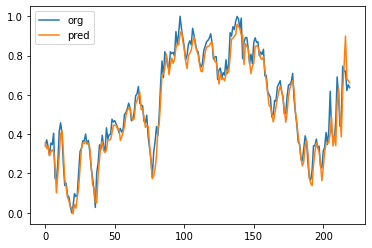

In [15]:
plt.plot(test_y)
plt.plot(net(test_X_tensor).data.numpy())
plt.legend(['org', 'pred'])
plt.show()